In [1]:
# The architecture of our CNN is given in Figure 1. The structure
# can be summarized as 10×10x1−26×26×4−100−M,
# where M is the number of classes. The input is a grayscale
# image patch. The size of the image patch is 28×28 pixels. Our
# CNN architecture contains only one convolution layer which
# consists of 4 kernels. The size of each kernel is 3 × 3 pixels.
# Unlike other traditional CNN architecture, the pooling layer is
# not used in our architecture. Then one fully connected layer
# of 100 neurons follows the convolution layer. The last layer
# consists of a logistic regression with softmax which outputs
# the probability of each class, such that

In [2]:
from __future__ import print_function
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import cv2
from PIL import Image

In [3]:
'''
Get train data
'''
# training_data = pickle.load(open('training_data.pkl','r'))
training_data = pickle.load(open('train_data_new.pkl','r'))

training_data = np.array(training_data)
np.random.shuffle(training_data)

In [4]:
'''
Get Validation data
'''
# validation_data = pickle.load(open('validation_data.pkl','r'))
validation_data = pickle.load(open('validation_data_new.pkl','r'))

validation_data = np.array(validation_data)

In [5]:
'''
Get Test data
'''
# test_data = pickle.load(open('test_data.pkl','r'))
test_data = pickle.load(open('test_data_new.pkl','r'))

test_data = np.array(test_data)

In [6]:
class Net(nn.Module):

    def __init__(self): # DO NOT HARDCODE
        super(Net, self).__init__()
        # 1 input image channel 10x10, 4 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(1, 4, 3)
#         self.dropout = nn.Dropout(0.2)
        # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(4 * 8 * 8, 100)
        self.fc1 = nn.Linear(4 * 12 * 12, 100)
        self.fc2 = nn.Linear(100, 1) #Number of classes = 'text'
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.num_flat_features(x))
#         x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        out = self.sigmoid(x)
#         out = F.log_softmax(x)
        return out

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
# Preparing the data
trainloader = DataLoader(training_data.tolist(), batch_size=1, shuffle=True)
validloader = DataLoader(validation_data.tolist())
testloader = DataLoader(test_data.tolist())

In [10]:
def validation_function(validloader, net, optimizer, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    for i, data in enumerate(validloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels_var = Variable(inputs.unsqueeze(0).float(), volatile=True), Variable(labels.float(), volatile=True)

        outputs = net(inputs)
        loss = criterion(outputs, labels_var.unsqueeze(-1))

        # print statistics
        running_loss += loss.data[0]
        
        predicted = torch.ge(outputs.data, torch.FloatTensor([0.5])) # Because batch size is 1
#         _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.long() == labels).sum()
    
    print("******validation*** running_loss = ",running_loss/float(i+1))
    print('Accuracy of the network on the 1728 validation images: %d %%' % (100 * correct / total))
    

In [11]:
def test_function(testloader, net, optimizer, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    predicted_list = []
    for i, data in enumerate(testloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
#         inputs, labels_var = Variable(inputs.unsqueeze(0).float()), Variable(labels.long())
        inputs, labels_var = Variable(inputs.unsqueeze(0).float()), Variable(labels.float())

        outputs = net(inputs)
#         loss = criterion(outputs, labels_var)
        loss = criterion(outputs, labels_var.unsqueeze(-1))
        
        # print statistics
        running_loss += loss.data[0]

        predicted = torch.ge(outputs.data, torch.FloatTensor([0.5])) # Because batch size is 1
#         _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        correct += (predicted.long() == labels).sum()
    
    print("******test*** running_loss = ",running_loss/float(i+1))
    print('Accuracy of the network on the 10368 test images: %d %%' % (100 * correct / total))
    return predicted_list
    

In [12]:
def train_function(trainloader, net, optimizer, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels_var = Variable(inputs.unsqueeze(0).float()), Variable(labels.float())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels_var.unsqueeze(-1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.numpy()[0]
    
        predicted = torch.ge(outputs.data, torch.FloatTensor([0.5])) # Because batch size is 1
#         _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.long() == labels).sum()
    print("****** running_loss = ",running_loss/float(i+1))

    print('Accuracy of the network on the 21643 train images: %d %%' % (100 * correct / total))
    return 

In [13]:
# Training Phase
net = Net()
# criterion =  nn.NLLLoss() #nn.CrossEntropyLoss()
criterion =  nn.BCELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer.zero_grad()

for epoch in range(20):  # loop over the dataset multiple times
    train_function(trainloader, net, optimizer, criterion)
    validation_function(validloader, net, optimizer, criterion)
#     predicted_list = test_function(testloader, net, optimizer, criterion)
    print("-----------------------------")

****** running_loss =  0.670638093567
Accuracy of the network on the 21643 train images: 61 %
******validation*** running_loss =  0.64688098778
Accuracy of the network on the 1728 validation images: 65 %
-----------------------------
****** running_loss =  0.651444816306
Accuracy of the network on the 21643 train images: 63 %
******validation*** running_loss =  0.624656138411
Accuracy of the network on the 1728 validation images: 66 %
-----------------------------
****** running_loss =  0.635574142445
Accuracy of the network on the 21643 train images: 65 %
******validation*** running_loss =  0.597281337315
Accuracy of the network on the 1728 validation images: 70 %
-----------------------------
****** running_loss =  0.621352197161
Accuracy of the network on the 21643 train images: 66 %
******validation*** running_loss =  0.581506395484
Accuracy of the network on the 1728 validation images: 72 %
-----------------------------
****** running_loss =  0.60116117146
Accuracy of the network 

In [14]:
# IGNORE THE CODE FROM HERE

new_pr = []
for pr in predicted_list:
    new_pr.append(pr[0])
new_pr = np.array(new_pr) 
new_pr = new_pr.reshape(12,36,24)
sample= np.array(new_pr[0])

NameError: name 'predicted_list' is not defined

In [55]:
(len(predicted_list) - np.count_nonzero(y_Test))/float(len(predicted_list))

0.6121809637888141

In [121]:
predicted_list = np.array(predicted_list)
predicted_list = predicted_list.reshape(12,864)
predicted_list

array([[
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
, ...,
        
 1
[torch.LongTensor of size 1]
,
        
 1
[torch.LongTensor of size 1]
, 
 1
[torch.LongTensor of size 1]
],
       [
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
,
        
 1
[torch.LongTensor of size 1]
, ...,
        
 0
[torch.LongTensor of size 1]
,
        
 1
[torch.LongTensor of size 1]
, 
 1
[torch.LongTensor of size 1]
],
       [
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
, ...,
        
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
, 
 1
[torch.LongTensor of size 1]
],
       ..., 
       [
 1
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
, ...,
        
 1
[torch.LongTensor of size 1]
,
        
 0
[torch.LongTensor of size 1]
,

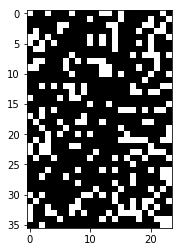

In [150]:
plt.imshow(sample, interpolation='nearest', cmap = 'gray')
plt.show()

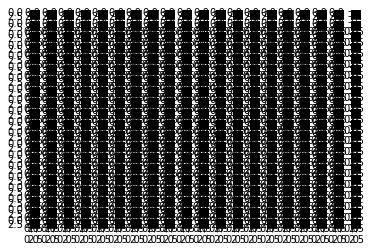

In [90]:


f, axarr = plt.subplots(20, 20)
for i in range(400):
    axarr[i/20,i%20].imshow(im_values[i+30], interpolation='bilinear', cmap='gray')
plt.show()

In [89]:
im_values = []
for pred in predicted_list:
    val = pred.numpy()
    if val[0] == 1:
        val[0] = 255
        im = np.full((5, 5), 0)
    else:
        val[0] = 1
        im = np.full((5, 5), 255)
    
    im_values.append(im)    

In [83]:
training_data = pickle.load(open('training_data.pkl','r'))

training_data = np.array(training_data)

X_Train = training_data[:,0]
y_Train = training_data[:,1]

N = len(X_Train)
H = X_Train[0].shape[0]
W = X_Train[0].shape[1]
trainTensor = torch.LongTensor(N, H, W)
for i in range(N):
    trainTensor[i] = torch.LongTensor(X_Train[i].tolist())
trainTensor = trainTensor.unsqueeze(1)

In [74]:
X_Train[0]

array([[109, 106, 105, 100,  98,  98,  98,  94,  95,  90],
       [ 38,  48,  44,  32,  38,  35,  36,  29,  33,  29],
       [ 24,  22,  24,  24,  21,  22,  22,  20,  19,  21],
       [  8,   8,   7,   8,  10,  10,   8,   8,   9,   8],
       [ 23,  21,  21,   8,  19,   3,  24,  30,  26,  22],
       [  7,   7,   5,   4,   7,   9,   8,   7,   6,   7],
       [  1,   0,   0,   0,   1,   7,   2,   2,   3,   1],
       [ 13,   7,   3,   4,   2,   7,  11,   4,   9,   9],
       [ 18,  23,  36,  18,  28,  28,  37,  47,  39,  50],
       [ 24,  35,  31,  51,  10,  55,  66,  77,  67,  61]], dtype=uint8)

In [71]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [85]:

dataiter = iter(trainloader)
images, label = dataiter.next()
images


(0 ,.,.) = 
  109  106  105  100   98   98   98   94   95   90
   38   48   44   32   38   35   36   29   33   29
   24   22   24   24   21   22   22   20   19   21
    8    8    7    8   10   10    8    8    9    8
   23   21   21    8   19    3   24   30   26   22
    7    7    5    4    7    9    8    7    6    7
    1    0    0    0    1    7    2    2    3    1
   13    7    3    4    2    7   11    4    9    9
   18   23   36   18   28   28   37   47   39   50
   24   35   31   51   10   55   66   77   67   61
[torch.ByteTensor of size 1x10x10]

In [119]:
inputs

Variable containing:
(0 ,0 ,.,.) = 
  244  247  238  233  232  218  229  228  214  231
  229  239  245  212  216  228  212  216  210  222
  226  225  233  219  236  222  233  235  234  229
  238  233  242  232  235  227  233  229  230  232
  240  237  226  229  226  234  208  234  218  231
  231  226  232  231  214  219  228  238  223  217
  191  212  191  226  214  159  186  220  211  213
  236  232  227  226  217  185  223  208  216  208
  229  224  228  233  227  219  226  208  217  208
  221  230  217  221  232  225  232  220  202  215
[torch.FloatTensor of size 1x1x10x10]

In [149]:
Variable(torch.arange(0, 2))

Variable containing:
 0
 1
[torch.FloatTensor of size 2]

In [52]:
input_t= Variable(torch.randn(3, 5), requires_grad=True)

In [53]:
input_t

Variable containing:
 0.3829  0.5494 -1.1376 -0.6053 -1.3948
 0.0361 -0.4575  1.0598 -0.5977 -2.6812
-1.4205 -1.7733 -0.0889  0.7921 -0.2184
[torch.FloatTensor of size 3x5]